In [1]:
import requests
import textwrap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from datetime import datetime
from bisect import bisect
from tqdm import tqdm
from matplotlib import rcParams
from dandi.dandiapi import DandiAPIClient
from collections import defaultdict
from scipy.optimize import curve_fit

# Ensure text is stored in a way Illustrator can edit
rcParams['pdf.fonttype'] = 42  
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.family'] = 'sans-serif'

In [ ]:
client = DandiAPIClient()

dandisets = list(client.get_dandisets())

neurodata_type_map = dict(
    ecephys=["LFP", "Units", "ElectricalSeries"],
    ophys=["PlaneSegmentation", "TwoPhotonSeries", "ImageSegmentation"],
    icephys=[
        "PatchClampSeries",
        "VoltageClampSeries",
        "CurrentClampSeries",
        "CurrentClampStimulusSeries",
    ],
)

def is_nwb(metadata):
    return any(
        x['identifier'] == 'RRID:SCR_015242'
        for x in metadata['assetsSummary'].get('dataStandard', {})
    )

def has_related_publication(metadata):
    return "relatedResource" in metadata and any(x.get("relation") == "dcite:IsDescribedBy" for x in metadata["relatedResource"])

data = defaultdict(list)
for dandiset in tqdm(dandisets):
    dandiset = dandiset.for_version("draft")
    identifier = dandiset.identifier
    metadata = dandiset.get_raw_metadata()
    
    if not is_nwb(metadata) or not dandiset.draft_version.size:
        continue
    data["identifier"].append(identifier)
    data["created"].append(dandiset.created)
    data["modified"].append(dandiset.modified)
    data["size"].append(dandiset.draft_version.size)
    if "species" in metadata["assetsSummary"] and len(metadata["assetsSummary"]["species"]):
        data["species"].append(metadata["assetsSummary"]["species"][0]["name"])
    else:
        data["species"].append(np.nan)
        
    data["nauthors"].append(
        sum(x.get('schemaKey',[]) == "Person" for x in metadata["contributor"]) if "contributor" in metadata else 0
    )
    
    
    for modality, ndtypes in neurodata_type_map.items():
        data[modality].append(
            any(x in ndtypes for x in metadata["assetsSummary"]["variableMeasured"])
        )
    
    data["numberOfSubjects"].append(metadata["assetsSummary"].get("numberOfSubjects", np.nan))
    data["numberOfFiles"].append(metadata["assetsSummary"].get("numberOfFiles", np.nan))        
    data["has_related_pub"].append(has_related_publication(metadata))

100%|██████████| 690/690 [02:29<00:00,  4.63it/s]


In [3]:
df = pd.DataFrame.from_dict(data)

In [4]:
species_replacement = {
    "Mus musculus - House mouse": "House mouse",
    "Rattus norvegicus - Norway rat": "Rat",
    "Brown rat": "Rat",
    "Rat; norway rat; rats; brown rat": "Rat",
    "Homo sapiens - Human": "Human",
    "Drosophila melanogaster - Fruit fly": "Fruit fly",
    "Danio rerio - Leopard danio": "Zebrafish",
    "Macaca mulatta - Rhesus monkey": "Rhesus monkey",
    "Danio rerio - Zebra fish": "Zebrafish",
    "Macaca nemestrina - Pig-tailed macaque": "Pig-tailed macaque",
    "Cricetulus griseus - Cricetulus aureus": "Chinese hamster",
    "Caenorhabditis elegans": "C. elegans",
    "Canis lupus familiaris - Dog": "Dog",
    "Oryctolagus cuniculus - Rabbits": "Rabbit",
    "Bos taurus - Cattle": "Cattle",
    "Macaca nemestrina - Pigtail macaque": "Pig-tailed macaque",
    "Macaca nemestrina": "Pig-tailed macaque",
    "Ooceraea biroi - Clonal raider ant": "Clonal raider ant",
    "Procambarus clarkii - Red swamp crayfish": "Red swamp crayfish",
    "Callithrix jacchus - Common marmoset": "Common marmoset",
    "Sus scrofa domesticus - Domestic pig": "Domestic pig",
    "Taeniopygia guttata - Zebra finch": "Zebra finch",
    "Meriones unguiculatus": "Mongolian gerbil",
    "Unidentified": np.nan
}

for key, val in species_replacement.items():
    df["species"] = df["species"].replace(key, val)

df

,identifier,created,modified,size,species,nauthors,ecephys,ophys,icephys,numberOfSubjects,numberOfFiles,has_related_pub
0,000003,2020-03-15 22:56:55.655000+00:00,2020-11-06 17:20:30.673000+00:00,2559248010229,House mouse,4,True,False,False,16.0,101,True
1,000004,2020-03-16 21:48:04.265000+00:00,2020-10-03 07:01:25.356000+00:00,6197474020,Human,13,True,False,False,59.0,87,True
2,000005,2020-03-16 22:52:44.757000+00:00,2020-04-09 20:59:35.377000+00:00,46436686324,House mouse,4,True,False,True,55.0,148,True
3,000006,2020-03-17 13:30:38.667000+00:00,2020-04-09 21:00:01.759000+00:00,139600500,House mouse,2,True,False,False,12.0,53,True
4,000007,2020-03-17 15:01:40.811000+00:00,2022-11-22 00:21:36.001459+00:00,199439472,House mouse,8,True,False,False,13.0,54,True
...,...,...,...,...,...,...,...,...,...,...,...,...
403,001525,2025-07-02 14:10:11.180813+00:00,2025-07-02 14:10:11.180835+00:00,2509409908,Chinese hamster,1,False,False,False,7.0,49,False
404,001530,2025-07-04 18:16:13.067910+00:00,2025-07-04 18:21:21.930310+00:00,2595419678304,House mouse,1,True,False,False,14.0,105,False
405,001533,2025-07-10 16:38:59.955109+00:00,2025-07-10 16:38:59.955129+00:00,422941584596,House mouse,1,True,False,False,139.0,459,False
406,001534,2025-07-11 18:49:45.394857+00:00,2025-07-11 18:49:45.394880+00:00,6697463686,House mouse,5,False,False,True,41.0,116,False


In [5]:
df["species"].unique()

array(['House mouse', 'Human', nan, 'Rat', 'Rhesus monkey', 'Fruit fly',
       'Zebrafish', 'Pig-tailed macaque', 'Chinese hamster', 'Dog',
       'Clonal raider ant', 'C. elegans', 'Rabbit', 'Cattle',
       'Red swamp crayfish', 'Domestic pig', 'Zebra finch',
       'Common marmoset', 'Mongolian gerbil'], dtype=object)

In [6]:
df["species"].value_counts()

species
House mouse           179
Rat                    55
Human                  49
Rhesus monkey          36
Zebrafish              21
Fruit fly              11
Cattle                  9
Chinese hamster         9
C. elegans              9
Pig-tailed macaque      7
Zebra finch             2
Clonal raider ant       2
Rabbit                  2
Red swamp crayfish      1
Domestic pig            1
Dog                     1
Common marmoset         1
Mongolian gerbil        1
Name: count, dtype: int64

In [7]:
# read in u24 metrics which include event, consultation, and reuse statistics
df_u24_metrics = pd.read_csv('nwb_statistics.csv', skiprows=1, index_col=0)

# clean up metrics
df_u24_metrics = (df_u24_metrics
    .assign(consultations=lambda x: x['tool consultations'] + x['user consultations'])  # combine user and tool consultations
    .drop(["user consultations", "tool consultations"], axis=1)  # TODO - combine allen + data reuse when updated
    .cumsum())  # convert to cumulative sum
df_u24_metrics

,event registrants,community tools,data reuse publications,consultations
year,,,,
2017,30,0,6,0
2018,90,1,14,0
2019,176,2,22,0
2020,783,5,33,0
2021,1034,8,82,35
2022,1470,16,113,68
2023,1890,27,163,108
2024,2417,30,213,134
2025,2875,35,231,139


In [8]:
## combine u24 and dandi metrics and group by year
# n_dandisets
n_dandisets = (df['created'].dt.year
               .value_counts()
               .sort_index()
               .cumsum())

# n_bytes of data
n_terabytes = (df.groupby(df['modified'].dt.year)['size']
               .sum()  # sum by year
               .sort_index()  # should be sorted but just in case
               .cumsum()/10**12)  # cumsum by year and convert to TB

# n_sessions
n_sessions = (df.groupby(df['modified'].dt.year)['numberOfFiles']
               .sum()  # sum by year
               .sort_index()  # should be sorted but just in case
               .cumsum())  # cumsum by year

# n_species
unique_species = set()
species_count = dict()
for year, group in df.groupby(df['modified'].dt.year):
    unique_species.update(group['species'])
    species_count[year] = len(unique_species)
n_species = pd.DataFrame(data=species_count.values(), index=species_count.keys(), columns=['species'])

df_by_year = pd.concat([n_dandisets, n_terabytes, n_sessions, n_species, df_u24_metrics], axis=1)
df_by_year = (df_by_year
              .reset_index()
              .rename(columns={'count': 'datasets on DANDI',
                               'species':'species on DANDI',
                               'numberOfFiles':'sessions on DANDI',
                               'size': 'TBs on DANDI',
                               'index': 'year'})
             .sort_values('year')
             .query('year >= 2020')  # just for viz purposes
             .melt(id_vars=['year'], var_name='metric', value_name='value'))

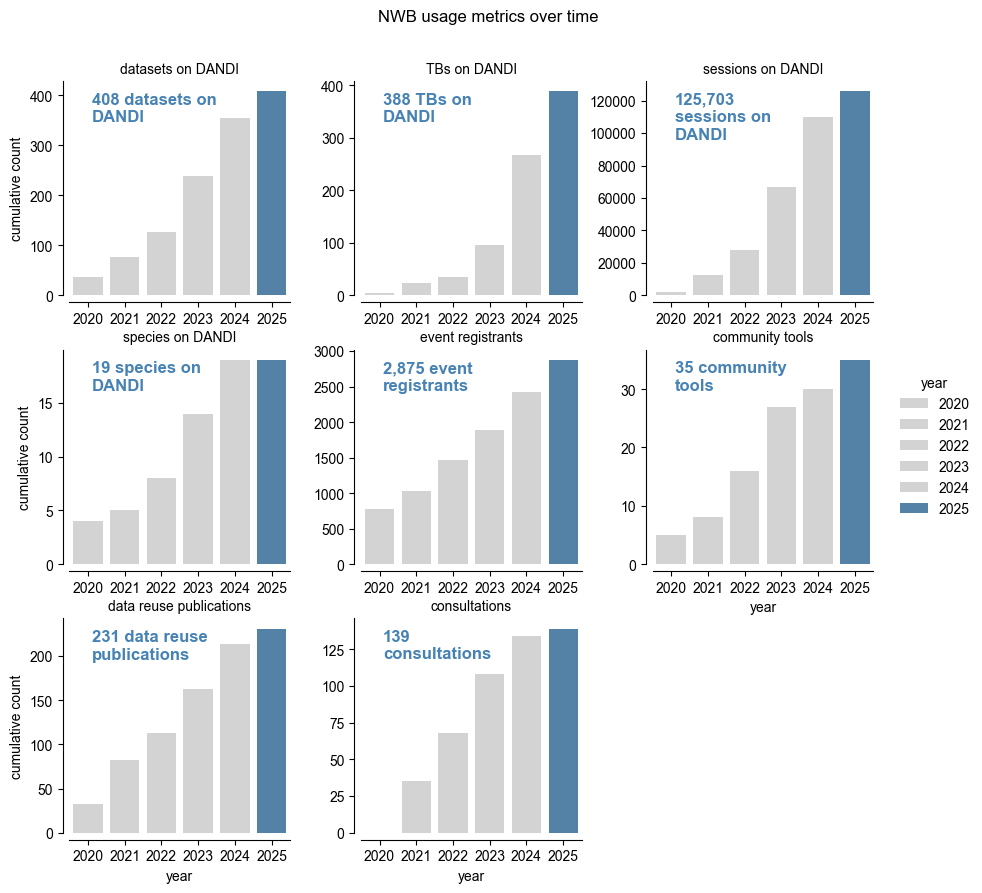

In [9]:
# plot the data by year
colors = ['lightgrey'] * (len(df_by_year['year'].unique()) - 1) + ['steelblue']
g = sns.catplot(data=df_by_year, x='year', y='value', kind='bar', hue='year',
                col='metric', col_wrap=3, sharey=False, sharex=True,
                height=3, palette=colors)

def add_2025_text(data, **kwargs):
    ax = plt.gca()
    value_2025 = data[data['year'] == 2025]['value'].iloc[0]
    text = f'{value_2025:,.0f} {ax.get_title()}'
    wrapped_text = '\n'.join(textwrap.wrap(text, width=15))
    ax.text(0.1, 0.95, wrapped_text, 
            transform=ax.transAxes, 
            fontsize=12, 
            color='steelblue',
            fontweight='bold',
            ha='left', va='top')

# update labels and text
(g.set_axis_labels("year", "cumulative count")
  .set_titles("{col_name}")
  .map_dataframe(add_2025_text)
  .tight_layout()
  .despine(offset=5)
  .fig.suptitle('NWB usage metrics over time')
  )
    
# adjust legend and spacing
plt.subplots_adjust(top=0.9)

# save figure
plt.savefig('key_usage_metrics_bar.pdf', format='pdf')

In [10]:
# plot the data by month for curve fit
n_terabytes_by_month = (df.groupby(df['modified'].dt.to_period('M'))['size']
               .sum()  # sum by year
               .sort_index()  # should be sorted but just in case
               .cumsum()/10**12)  # cumsum by year and convert to TB

n_dandisets_by_month = (df['created'].dt.to_period('M')
               .value_counts()
               .sort_index()
               .cumsum())

n_sessions_by_month = (df.groupby(df['modified'].dt.to_period('M'))['numberOfFiles']
               .sum()  # sum by year
               .sort_index()  # should be sorted but just in case
               .cumsum())  # cumsum by year

df_by_month = pd.concat([n_dandisets_by_month, n_terabytes_by_month, n_sessions_by_month], axis=1)
df_by_month
df_by_month = (df_by_month
              .reset_index()
              .rename(columns={'count': 'datasets on DANDI',
                               'numberOfFiles':'sessions on DANDI',
                               'size': 'TBs on DANDI',
                               'index': 'time'})
              .assign(time=lambda x: x['time'].dt.to_timestamp())
              .sort_values('time')
              .dropna()
              .melt(id_vars=['time'], var_name='metric', value_name='value'))
df_by_month

/var/folders/50/_vs4yj0n27jbxcv71kvzktqr0000gp/T/ipykernel_45255/4188303649.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  n_terabytes_by_month = (df.groupby(df['modified'].dt.to_period('M'))['size']
/var/folders/50/_vs4yj0n27jbxcv71kvzktqr0000gp/T/ipykernel_45255/4188303649.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  n_dandisets_by_month = (df['created'].dt.to_period('M')
/var/folders/50/_vs4yj0n27jbxcv71kvzktqr0000gp/T/ipykernel_45255/4188303649.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  n_sessions_by_month = (df.groupby(df['modified'].dt.to_period('M'))['numberOfFiles']


,time,metric,value
0,2020-04-01,datasets on DANDI,16.0
1,2020-05-01,datasets on DANDI,19.0
2,2020-06-01,datasets on DANDI,20.0
3,2020-10-01,datasets on DANDI,29.0
4,2020-11-01,datasets on DANDI,32.0
...,...,...,...
172,2025-03-01,sessions on DANDI,113728.0
173,2025-04-01,sessions on DANDI,116666.0
174,2025-05-01,sessions on DANDI,120319.0
175,2025-06-01,sessions on DANDI,122870.0


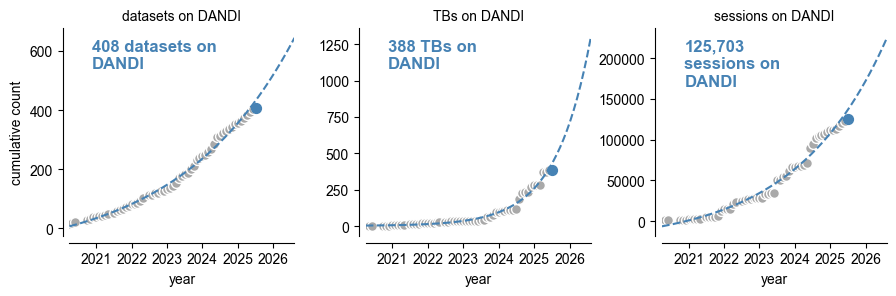

In [11]:
# plot the data metrics and a projection of future values
def exponential_func(x, a, b, c):
    return a * np.exp(b * x) + c

def add_exponential_fit(data, **kwargs):
    ax = plt.gca()
    
    # Convert datetime to numeric for fitting
    x_data = data['time']
    y_data = data['value'].values
    x_numeric = (x_data - x_data.min()).dt.days.values
    
    # Fit exponential curve
    popt, pcov = curve_fit(exponential_func, x_numeric, y_data, 
                          p0=[1, 0.01, 0], maxfev=5000)
    
    # Extend the curve into the future
    future_days = 365 * 1.1  # 1.1 years
    x_extended = np.linspace(x_numeric.min(), x_numeric.max() + future_days, 200)
    y_extended = exponential_func(x_extended, *popt)
    
    # Convert back to datetime for plotting
    x_plot = x_data.min() + pd.to_timedelta(x_extended, unit='D')
    
    # Plot future projection (dashed line)
    ax.plot(x_plot, y_extended, 
            '--', color='steelblue', linewidth=1.5, label='Future projection', zorder=10)
    
    # Extend x-axis to show the projection
    ax.set_xlim(x_data.min(), x_plot.max())

def add_last_point_highlight_and_text(data, **kwargs):
    ax = plt.gca()
    last_point = data.iloc[-1]

    # add text
    text = f'{last_point['value']:,.0f} {ax.get_title()}'
    wrapped_text = '\n'.join(textwrap.wrap(text, width=15))
    ax.text(0.1, 0.95, wrapped_text, 
            transform=ax.transAxes, 
            fontsize=12, 
            color='steelblue',
            fontweight='bold',
            ha='left', va='top')

    # add highlight
    ax.scatter(last_point['time'], last_point['value'], 
               color='steelblue', s=50, linewidth=1, zorder=5)

# plot the data
g = sns.FacetGrid(df_by_month, col='metric', col_wrap=3, 
                  sharey=False, sharex=True, height=3)

(g.map_dataframe(sns.scatterplot, x='time', y='value', color='darkgrey', s=50, linewidth=1)
  .map_dataframe(add_exponential_fit)
  .set_titles("{col_name}")
  .map_dataframe(add_last_point_highlight_and_text)
  .set_axis_labels("year", "cumulative count")
  .tight_layout()
  .despine(offset=5))

# save figure
plt.savefig('data_metrics_projection.pdf', format='pdf')

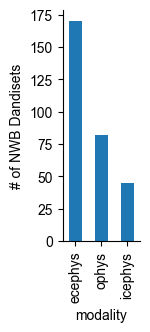

In [12]:
fig, ax = plt.subplots(figsize=(1, 3))

df[["ecephys", "ophys", "icephys"]].sum().plot.bar(ax=ax)
ax.set_xlabel("modality")
ax.set_ylabel("# of NWB Dandisets")
sns.despine()
ax.figure.savefig(
    "modality.png",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

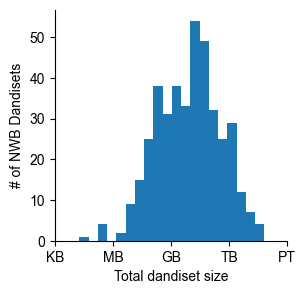

In [13]:
logsize = np.log10(df["size"])
#logsize[logsize < 0] = np.nan

fig, ax = plt.subplots(figsize=(3, 3))
ax = logsize.plot.hist(bins=20, ax=ax)
ax.set_xticks([3, 6, 9, 12, 15])
ax.set_xticklabels(["KB", "MB", "GB", "TB", "PT"])
ax.set_xlabel("Total dandiset size")
ax.set_ylabel("# of NWB Dandisets")
sns.despine()
ax.figure.savefig(
    "size.png",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

In [14]:
df["size"].sum()/(1e12)  #TB

np.float64(388.235131370256)

In [15]:
df["size"].sum()

np.int64(388235131370256)

In [16]:
len(df)

408

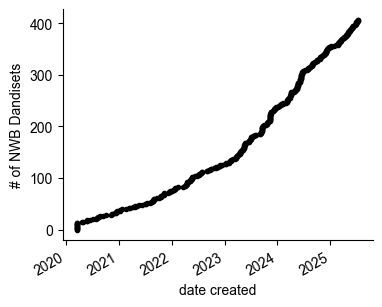

In [17]:
fig, ax = plt.subplots(figsize=(4,3))

ax.plot(df['created'], np.arange(len(df)), 'k.')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_ylabel('# of NWB Dandisets')
ax.set_xlabel("date created")
sns.despine()
ax.figure.savefig("date.png", bbox_inches="tight", dpi=300, transparent=True)

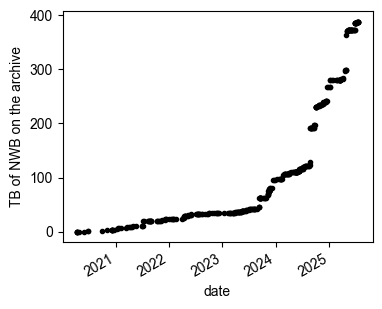

In [18]:
fig, ax = plt.subplots(figsize=(4,3))

order = np.argsort(df['modified'])

ax.plot(df['modified'][order], df['size'][order].cumsum()/10**12, '.k')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_xlabel("date")
_ = ax.set_ylabel("TB of NWB on the archive")

In [19]:
df.columns

Index(['identifier', 'created', 'modified', 'size', 'species', 'nauthors',
       'ecephys', 'ophys', 'icephys', 'numberOfSubjects', 'numberOfFiles',
       'has_related_pub'],
      dtype='object')

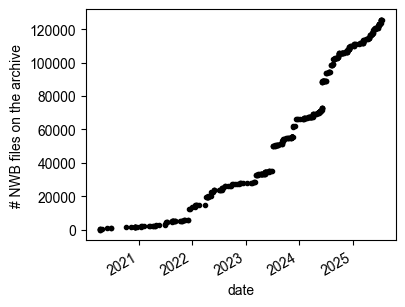

In [20]:
fig, ax = plt.subplots(figsize=(4,3))

order = np.argsort(df['modified'])

ax.plot(df['modified'][order], df['numberOfFiles'][order].cumsum(), '.k')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_xlabel("date")
_ = ax.set_ylabel("# NWB files on the archive")

[Text(0, 9, 'GB'), Text(0, 12, 'TB'), Text(0, 15, 'PB')]

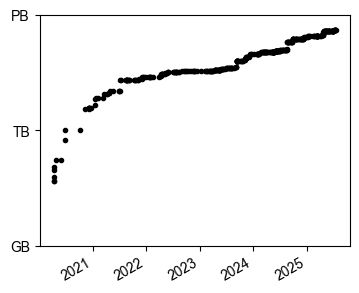

In [21]:
fig, ax = plt.subplots(figsize=(4,3))

order = np.argsort(df['modified'])

ax.plot(df['modified'][order], np.log10(df['size'][order].cumsum()), 'k.')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_yticks([9,12,15])
ax.set_yticklabels(["GB", "TB", "PB"])

(12.0, 15.0)

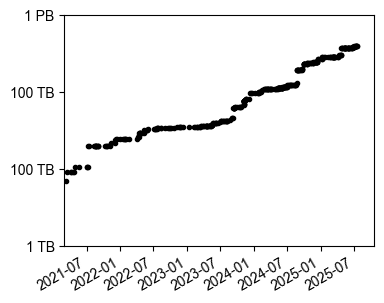

In [22]:
fig, ax = plt.subplots(figsize=(4,3))

order = np.argsort(df['modified'])

ax.plot(df['modified'][order], np.log10(df['size'][order].cumsum()), 'k.')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_yticks([12, 13, 14, 15])
ax.set_yticklabels(["1 TB", "100 TB", "100 TB", "1 PB"])
ax.set_xlim(datetime(2021, 3, 1), None)
ax.set_ylim(12, 15)

In [23]:
date_idx = df['modified'][order].apply(lambda x: pd.to_datetime(x)).dt.date > datetime(2021,3,1).date()

In [24]:
seconds_in_a_day = 86400
days = (df['modified'][order]).apply(lambda x: (x.replace(tzinfo=None) - datetime(2021,3,1)).total_seconds()/seconds_in_a_day/365.25)

Text(0.5, 0, 'date')

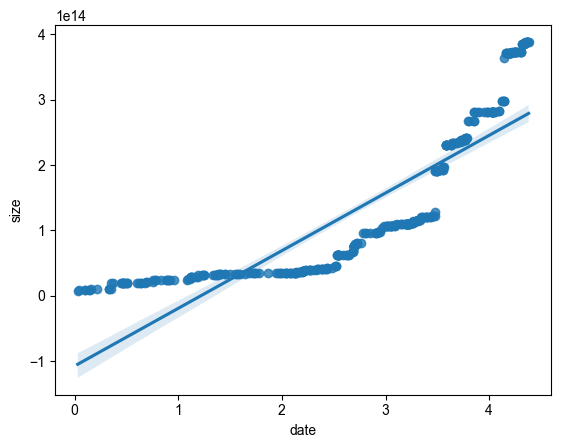

In [25]:
ax = sns.regplot(x=days[date_idx], y=df['size'][order].cumsum()[date_idx]);
ax.set_xlabel("date")
#ax.set_yticks([13, 14, 15])
#ax.set_yticklabels(["10 TB", "100 TB", "1 PB"])
#ax.set_yticks(12+np.log10(np.linspace(1,10,10)), minor=True)



Text(0, 0.5, 'total size (TB)')

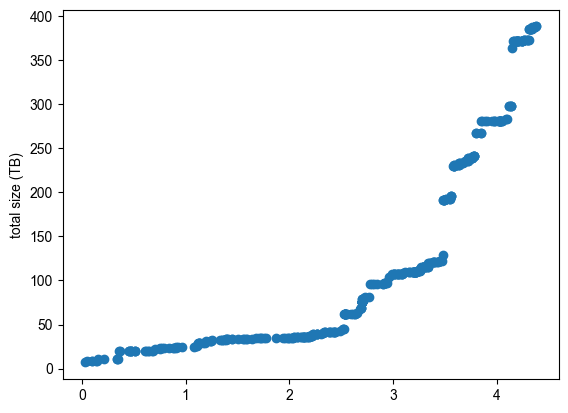

In [26]:
fig, ax = plt.subplots()
ax.plot(days[date_idx], df['size'][order].cumsum()[date_idx]/10**12, 'o')
ax.set_ylabel("total size (TB)")

(0.0, 3.0)

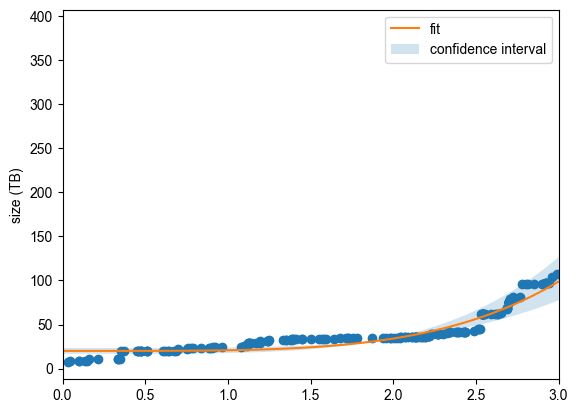

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

fig, ax = plt.subplots()


# define the power-law function to fit
def power_law_func(x, a, b, c):
    return a * x**b - c

popt, pcov = curve_fit(power_law_func, days[date_idx], df['size'][order].cumsum()[date_idx]/10**12)

# calculate the confidence intervals
perr = np.sqrt(np.diag(pcov))
confidence_interval = 1.96 * perr
lower_bound = popt - confidence_interval
upper_bound = popt + confidence_interval

# plot the result
x = np.linspace(0, 3, 100)
ax.plot(days[date_idx], df['size'][order].cumsum()[date_idx]/10**12, 'o')
ax.plot(x, power_law_func(x, *popt), label='fit')
ax.fill_between(x, power_law_func(x, *lower_bound), power_law_func(x, *upper_bound), alpha=0.2, label='confidence interval')
#plt.xscale('log')
#plt.yscale('log')
plt.legend()
ax.set_ylabel("size (TB)")
ax.set_xlim(0,3)


In [28]:
12+np.log10(np.linspace(1,10,10))

array([12.        , 12.30103   , 12.47712125, 12.60205999, 12.69897   ,
       12.77815125, 12.84509804, 12.90308999, 12.95424251, 13.        ])

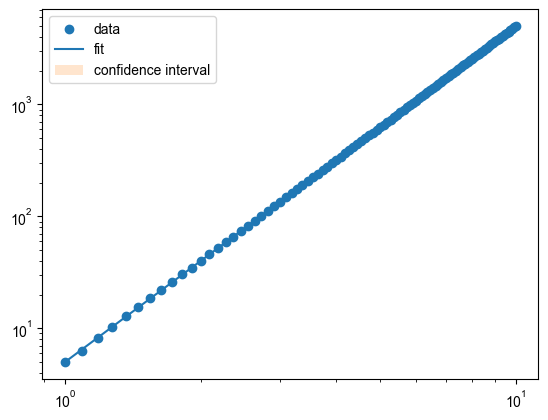

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# define the power-law function to fit
def power_law_func(x, a, b):
    return a * x**b

# generate some sample data
x = np.linspace(1, 10, 100)
y = 5 * x**(3) + np.random.normal(0, 0.2, size=len(x))

# fit the power-law function to the data
popt, pcov = curve_fit(power_law_func, x, y)

# calculate the confidence intervals
perr = np.sqrt(np.diag(pcov))
confidence_interval = 1.96 * perr
lower_bound = popt - confidence_interval
upper_bound = popt + confidence_interval

# plot the result
plt.scatter(x, y, label='data')
plt.plot(x, power_law_func(x, *popt), label='fit')
plt.fill_between(x, power_law_func(x, *lower_bound), power_law_func(x, *upper_bound), alpha=0.2, label='confidence interval')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


In [30]:
times = df['modified'][order]
days = (times - times.iloc[0]).apply(lambda x: x.total_seconds()/86400)

In [31]:
import scipy

x = days
y = df['size'][order].cumsum()

coefs, _ = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y)


/Users/smprince/Documents/code/nwb-project-analytics/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/smprince/Documents/code/nwb-project-analytics/.venv/lib/python3.13/site-packages/scipy/optimize/_minpack_py.py:1024: RuntimeWarning: overflow encountered in square
  cost = np.sum(infodict['fvec'] ** 2)
/var/folders/50/_vs4yj0n27jbxcv71kvzktqr0000gp/T/ipykernel_45255/1395594452.py:6: OptimizeWarning: Covariance of the parameters could not be estimated
  coefs, _ = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y)


In [32]:
coefs

array([1., 1.])

In [33]:
[1000**x for x in range(2,6)]
["MB", "GB", "TB", "PB"]

['MB', 'GB', 'TB', 'PB']

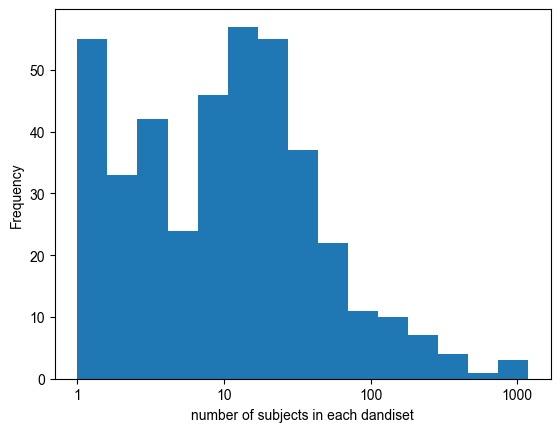

In [34]:
lognum = np.log10(df["numberOfSubjects"])


ax = lognum.plot.hist(bins=15)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels([1, 10, 100, 1000])
ax.set_xlabel("number of subjects in each dandiset")
ax.figure.savefig("subjects.svg", bbox_inches="tight")

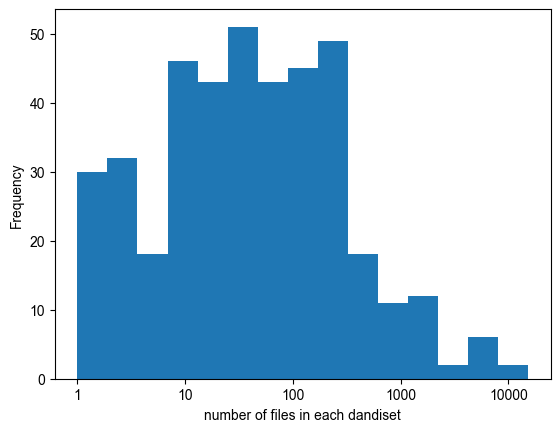

In [35]:
lognum = np.log10(df["numberOfFiles"])


ax = lognum.plot.hist(bins=15)
orders = np.arange(5)
ax.set_xticks(orders)
ax.set_xticklabels([10**x for x in orders])
ax.set_xlabel("number of files in each dandiset")
ax.figure.savefig("files.svg", bbox_inches="tight")

In [36]:
identifiers = df[
    (df["species"] == "House mouse") & 
    (df["numberOfSubjects"] > 40) & 
    (df["ecephys"] == True)
]["identifier"].values

In [37]:
# find only NWB files with male subjects
asset_list = []
for dandiset in dandisets[:3]:
    if dandiset.identifier not in identifiers:
        continue
    for asset in tqdm(list(dandiset.get_assets())):
        asset_metadata = asset.get_metadata()
        if asset_metadata.wasAttributedTo is not None:
            sex = asset_metadata.wasAttributedTo[0].sex 
            if sex and sex.name == "Male":
                asset_list.append(asset)
len(asset_list)

100%|██████████| 148/148 [00:16<00:00,  9.20it/s]


79